In [6]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.svm import SVR
import numpy as np

import seaborn as sns
sns.set(rc={'figure.figsize':(24,16)})

import matplotlib.pyplot as plt

In [7]:
ames_data_path = './AmesHousing.csv'
ames_data = pd.read_csv(ames_data_path)
#ames_data


## Identify Missing Data

In [8]:
ames_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

Features with missing values:
Lot Frontage     2440 non-null   float64
    Can't see why they are missing, no obvious relation to lot shape
    small difference between culdsac and the rest, will fill with average per category in lot config
    Cleaned

Alley            198 non-null    object
    Cleaned
    
Mas Vnr Type     2907 non-null   object
    Cleaned
Mas Vnr Area     2907 non-null   float64
    Cleaned

Bsmt Qual        2850 non-null   object 
Bsmt Cond        2850 non-null   object 
Bsmt Exposure    2847 non-null   object 
BsmtFin Type 1   2850 non-null   object 
BsmtFin SF 1     2929 non-null   float64
BsmtFin Type 2   2849 non-null   object 
BsmtFin SF 2     2929 non-null   float64
Bsmt Unf SF      2929 non-null   float64
Total Bsmt SF    2929 non-null   float64
Bsmt Full Bath   2928 non-null   float64
Bsmt Half Bath   2928 non-null   float64

Electrical       2929 non-null   object
    Cleaned


Fireplace Qu     1508 non-null   object
    Cleaned
    
Garage Type      2773 non-null   object 
Garage Yr Blt    2771 non-null   float64
Garage Finish    2771 non-null   object 
Garage Cars      2929 non-null   float64
Garage Area      2929 non-null   float64
Garage Qual      2771 non-null   object 
Garage Cond      2771 non-null   object 

Pool QC          13 non-null     object 
    Cleaned
Fence            572 non-null    object
    Cleaned
Misc Feature     106 non-null    object
    Cleaned

<AxesSubplot:>

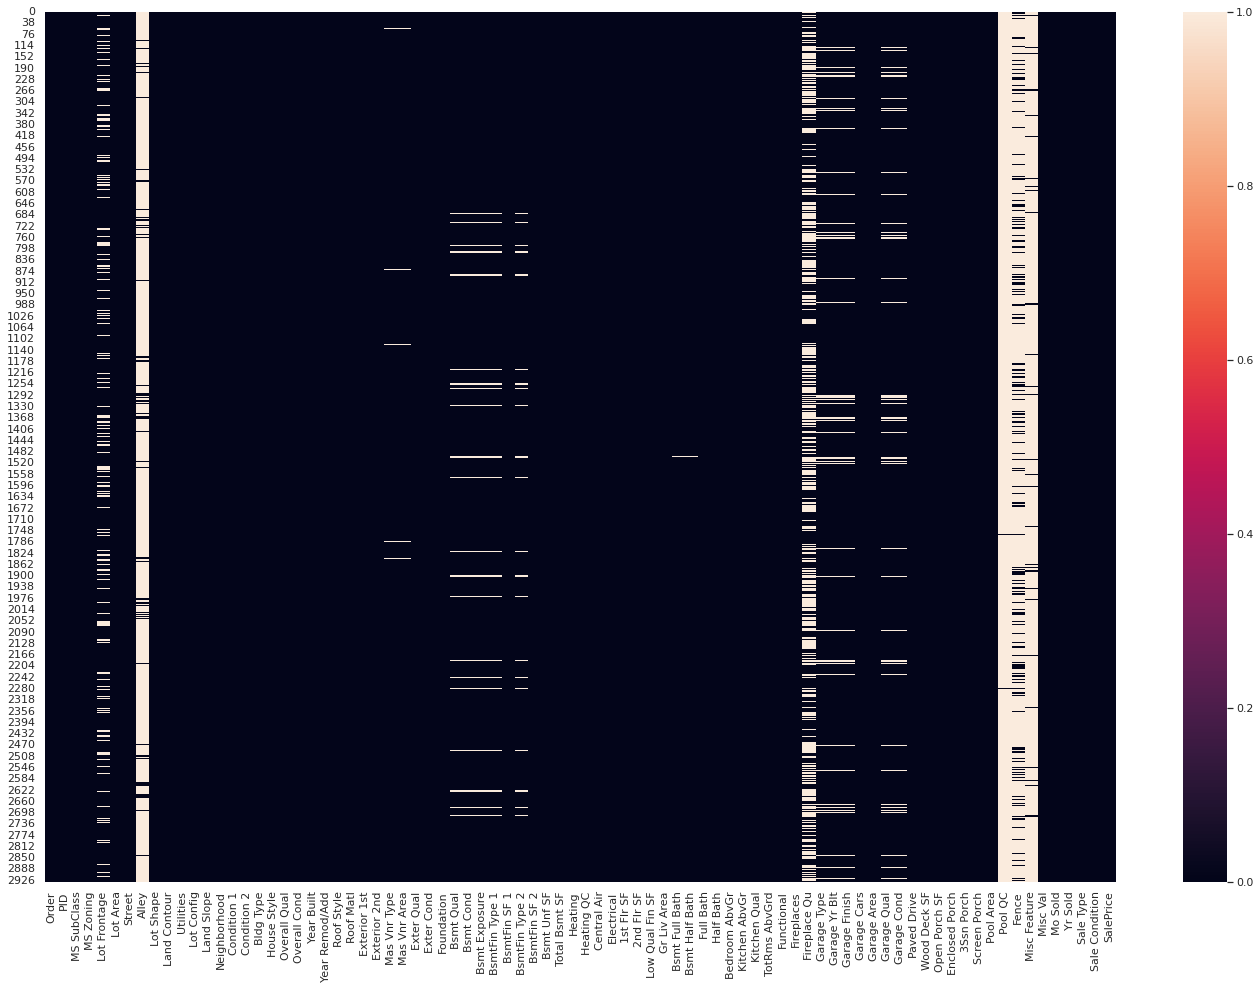

In [9]:
sns.heatmap(ames_data.isnull(), cbar=True)

It appears that many of the basement features and garage features share empty rows. assume that these properties do not have basements and/or garages and the data can either be left as NaN or be set to zero, depending on the algorithm being used

In [10]:
#ames_data[{'Misc Feature','Misc Val'}]

It appears that Misc Feature/Value are also paired, this data might be of interest in further analysis as information about extra garages could affect the price of a home but for this analysis we will be ignoring it due to the sparcity of the data as it only contain 106 non-null rows in a 2390 row data set

In [11]:
ames_data.drop(columns=['Misc Feature','Misc Val'],inplace=True)

In [12]:
#ames_data.loc[ames_data['Alley'].notnull()]

The feature Alley appears to only be populated when the property also has access to an alley, it is safe to assume that properties that don't have an entry here simply don't have an alley, going to replace pave and gravel with an enum score gravel = 1 pave = 2 no alley =-1

In [13]:
alley_dict = {'Pave': 2, 'Grvl': 1}
ames_data.replace({'Alley': alley_dict},inplace=True)
ames_data['Alley'].fillna(value=-1,inplace=True)
#ames_data

In [14]:
#ames_data.loc[ames_data['Pool Area']!=0,'Pool Area'].hist(bins=100)

Pool QC (Ordinal): Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
       
Going to replace this with a score 1-4 with 4 being the best and make No Pool -1

In [15]:
pool_qc_dict = {'Ex': 4, 'Gd': 3, 'TA':2 , 'Fa':1}
ames_data.replace({'Pool QC': pool_qc_dict},inplace=True)
ames_data['Pool QC'].fillna(value=-1,inplace=True)
#ames_data

Might want to include either side by side plots or something to talk about why split on lot config

Mean Lot frontage fraction by lot config
Corner  0.008498
CulDSac 0.004779
FR2     0.007026
FR3     0.008958
Inside  0.007981

In [16]:
ames_data.loc[(ames_data['Lot Config']=='Corner') & (ames_data['Lot Frontage'].isnull()) ,'Lot Frontage'] = ames_data.loc[(ames_data['Lot Config']=='Corner') & (ames_data['Lot Frontage'].isnull()) ,'Lot Area']*0.008498
ames_data.loc[(ames_data['Lot Config']=='CulDSac') & (ames_data['Lot Frontage'].isnull()) ,'Lot Frontage'] = ames_data.loc[(ames_data['Lot Config']=='CulDSac') & (ames_data['Lot Frontage'].isnull()) ,'Lot Area']*0.004779
ames_data.loc[(ames_data['Lot Config']=='FR2') & (ames_data['Lot Frontage'].isnull()) ,'Lot Frontage'] = ames_data.loc[(ames_data['Lot Config']=='FR2') & (ames_data['Lot Frontage'].isnull()) ,'Lot Area']*0.007026
ames_data.loc[(ames_data['Lot Config']=='FR3') & (ames_data['Lot Frontage'].isnull()) ,'Lot Frontage'] = ames_data.loc[(ames_data['Lot Config']=='FR3') & (ames_data['Lot Frontage'].isnull()) ,'Lot Area']*0.008958
ames_data.loc[(ames_data['Lot Config']=='Inside') & (ames_data['Lot Frontage'].isnull()) ,'Lot Frontage'] = ames_data.loc[(ames_data['Lot Config']=='Inside') & (ames_data['Lot Frontage'].isnull()) ,'Lot Area']*0.007981
#ames_data

Fence Score Enum

In [17]:
fence_dict = {'GdPrv': 4, 'MnPrv': 3, 'GdWo':2 , 'MnWw':1}
ames_data.replace({'Fence': fence_dict},inplace=True)
ames_data['Fence'].fillna(value=-1,inplace=True)

Fireplace Score Enum

In [18]:
fireplace_qu_dict = {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1 }
ames_data.replace({'Fireplace Qu' : fireplace_qu_dict},inplace=True)
ames_data['Fireplace Qu'].fillna(value=-1,inplace=True)
#ames_data

Masonry Veneer Type and Area
Missing values are all overwhelmingly Poured Concrete foundations and not cinderblock and siding/shingles. It appears that these properties do not have a masonry veneer. Will fill data with 'None' for type and 0 for area

In [19]:
ames_data['Mas Vnr Type'].fillna(value='None',inplace=True)
ames_data['Mas Vnr Area'].fillna(value=0,inplace=True)
#ames_data

Electrical
Missing entry was built in 2006 and all houses built in 2006 had Standard Circuit Breakers & Romex so will fill in with that

Functional stuff

In [20]:
functional_dict = {'Typ': 8, 'Min1': 7, 'Min2':6 , 'Mod':5, 'Maj1': 4, 'Maj2': 3, 'Sev':2 , 'Sal':1}
ames_data.replace({'Functional': functional_dict},inplace=True)
ames_data['Functional'].fillna(value=-1,inplace=True)

In [21]:
ames_data['Electrical'].fillna(value='SBrkr',inplace=True)

Garage stuff

In [22]:
garage_qu_cond_dict = {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1 }
ames_data.replace({'Garage Qual' : garage_qu_cond_dict},inplace=True)
ames_data['Garage Qual'].fillna(value=0,inplace=True)
ames_data.replace({'Garage Cond' : garage_qu_cond_dict},inplace=True)
ames_data['Garage Cond'].fillna(value=0,inplace=True)
garage_finish_dict = {'Fin': 3, 'RFn': 2, 'Unf':1,'NA':0}
ames_data.replace({'Garage Finish' : garage_finish_dict},inplace=True)
ames_data['Garage Finish'].fillna(value=-1,inplace=True)
paved_drive_dict = {'Y': 2, 'P': 1, 'N':0}
ames_data.replace({'Paved Drive' : paved_drive_dict},inplace=True)
ames_data['Paved Drive'].fillna(value=-1,inplace=True)
ames_data['Garage Yr Blt'].fillna(value=0,inplace=True)
ames_data['Garage Cars'].fillna(value=0,inplace=True)
ames_data['Garage Area'].fillna(value=0,inplace=True)
ames_data['Garage Type'].fillna(value='None',inplace=True)
#ames_data

In [23]:
basement_qu_cond_dict = {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1 }
ames_data.replace({'Bmst Qual' : basement_qu_cond_dict},inplace=True)
ames_data['Bsmt Qual'].fillna(value=0,inplace=True)
ames_data.replace({'Bmst Cond' : basement_qu_cond_dict},inplace=True)
ames_data['Bsmt Cond'].fillna(value=0,inplace=True)
basement_finish_dict = {'GLQ':6, 'ALQ': 5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1 }
ames_data.replace({'BsmtFin Type 1' : basement_finish_dict},inplace=True)
ames_data['BsmtFin Type 1'].fillna(value=0,inplace=True)
ames_data.replace({'BsmtFin Type 2' : basement_finish_dict},inplace=True)
ames_data['BsmtFin Type 2'].fillna(value=0,inplace=True)
basement_exposure_dict = {'Gd': 4, 'Av': 3, 'Mn':2, 'No':1}
ames_data.replace({'Bsmt Exposure ' : basement_exposure_dict},inplace=True)
ames_data['Bsmt Exposure'].fillna(value=0,inplace=True)
ames_data['BsmtFin SF 1'].fillna(value=0,inplace=True)
ames_data['BsmtFin SF 2'].fillna(value=0,inplace=True)
ames_data['Bsmt Unf SF'].fillna(value=0,inplace=True)
ames_data['Total Bsmt SF'].fillna(value=0,inplace=True)
ames_data['Bsmt Full Bath'].fillna(value=0,inplace=True)
ames_data['Bsmt Half Bath'].fillna(value=0,inplace=True)
#ames_data

<AxesSubplot:>

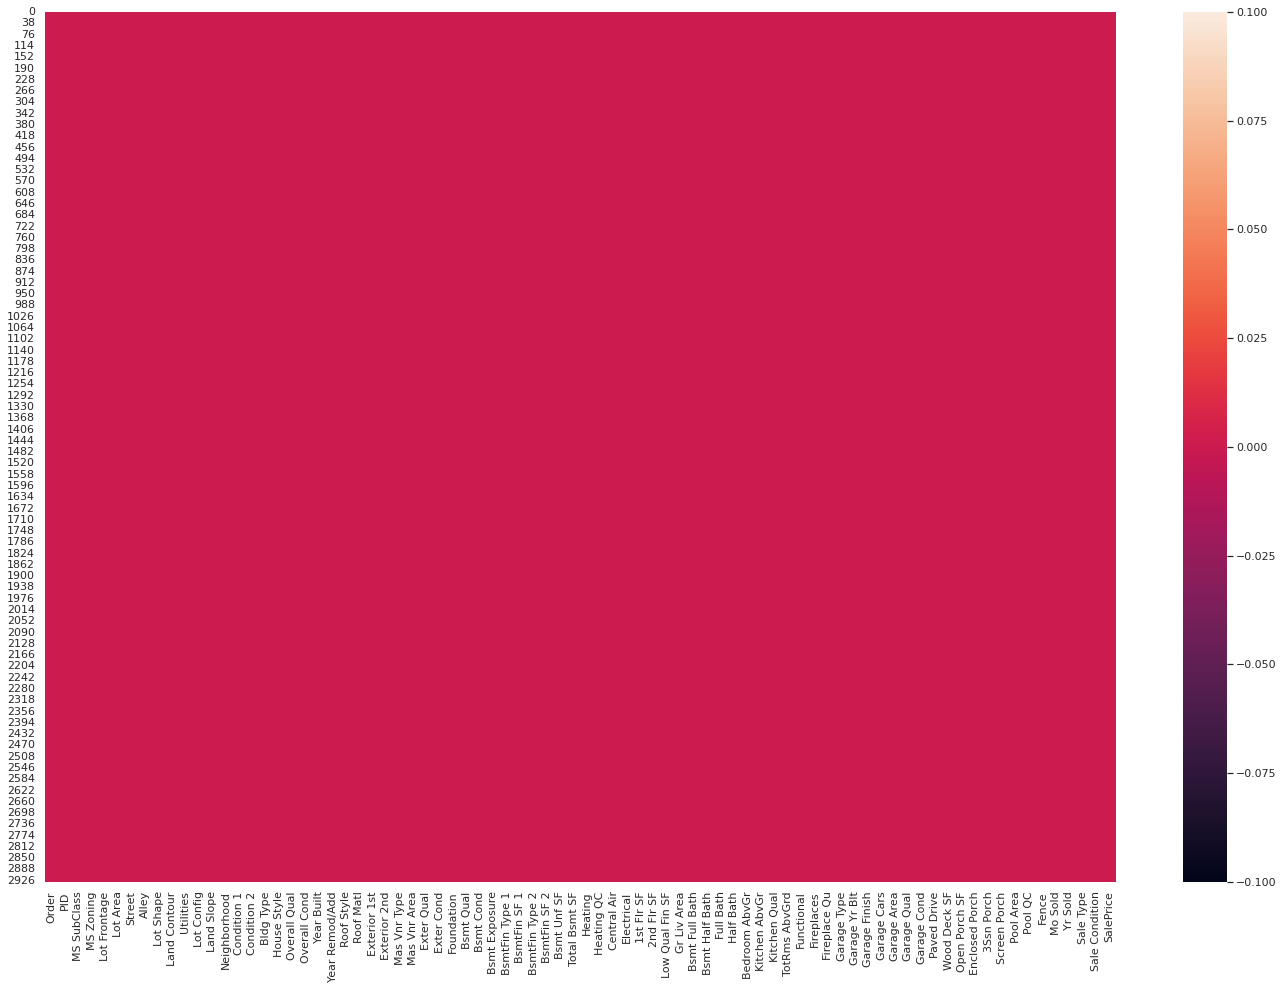

In [24]:
sns.heatmap(ames_data.isnull(), cbar=True)

In [25]:
neighborhood_dict = {'Blmngtn':1,'Blueste':2,'BrDale':3,'BrkSide':4,'ClearCr':5,'CollgCr':6,'Crawfor':7,'Edwards':9,'Gilbert':10,'Greens':11,'GrnHill':12,'IDOTRR':13,'Landmrk':14,'MeadowV':15,'Mitchel':16,'NAmes':17,'NPkVill':18,'NWAmes':19,'NoRidge':20,'NridgHt':21,'OldTown':22,'SWISU':23,'Sawyer':24,'SawyerW':25,'Somerst':26,'StoneBr':27,'Timber':28,'Veenker':29}
ames_data.replace({'Neighborhood' : neighborhood_dict},inplace=True)

In [26]:
ames_data.to_csv('./Cleaned_AmesHousing.csv',index=False)

In [27]:
correlations = ames_data.corr()[['SalePrice']].sort_values('SalePrice')
#correlations.index

<AxesSubplot:>

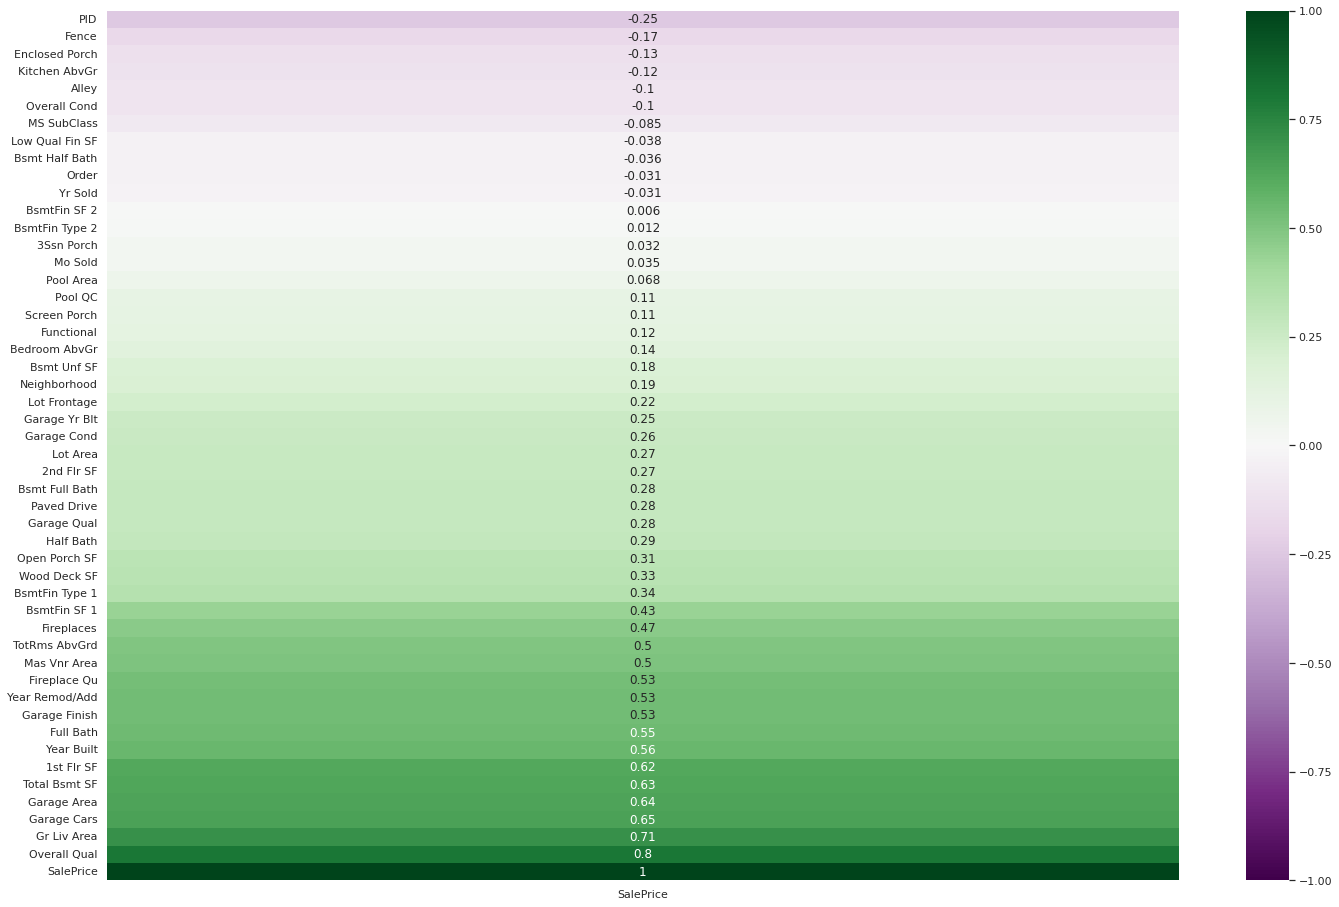

In [28]:
sns.heatmap(correlations,annot = True, vmin = -1, vmax = 1,cmap='PRGn')